## **1. Setup and Data Loading**

### **1.1 Import Libraries**

The following libraries are used for data manipulation, visualization, statistical testing, and machine learning.

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

### **1.2 Load Dataset**

The synthetic dataset (rice_synthetic_data.csv) is loaded for analysis.

In [3]:
# Load the dataset
data_path = "data/rice_cultivation_daily_dataset.csv"
df = pd.read_csv(data_path)
df.head()

,season,average_day_temp,average_night_temp,daily_sunshine_hours,daily_rainfall,suitability
0,kharif,28.6,21.3,7.572613,13.114609,suitable
1,rabi,25.9,21.5,5.692076,0.000000,not suitable
2,rabi,26.0,19.9,11.612907,0.000000,not suitable
3,kharif,27.1,20.2,8.504957,22.802553,suitable
4,pre-kharif,25.7,22.5,7.830067,5.836964,suitable


## **2. Exploratory Data Analysis (EDA)**

## **2.1 Data Overview**

Examine the dataset’s structure and summary statistics.

In [4]:
# Observe the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   season                10000 non-null  object 
 1   average_day_temp      10000 non-null  float64
 2   average_night_temp    10000 non-null  float64
 3   daily_sunshine_hours  10000 non-null  float64
 4   daily_rainfall        10000 non-null  float64
 5   suitability           10000 non-null  object 
dtypes: float64(4), object(2)
memory usage: 468.9+ KB


In [5]:
# Observe the data statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
average_day_temp,10000.0,27.781290,3.265903,15.500000,25.600000,27.800000,29.800000,42.500000
average_night_temp,10000.0,21.238280,1.630434,14.900000,20.200000,21.200000,22.300000,30.000000
daily_sunshine_hours,10000.0,7.852937,1.932276,0.720779,6.499464,7.742585,9.185826,12.000000
daily_rainfall,10000.0,5.353893,7.620658,0.000000,0.000000,0.000000,9.890116,63.413649


### **2.2 Data Distribution**

Visualize numerical and categorical features to understand distributions.

- **Numerical Features**: Histograms with kernel density estimation (KDE) for continuous variables.

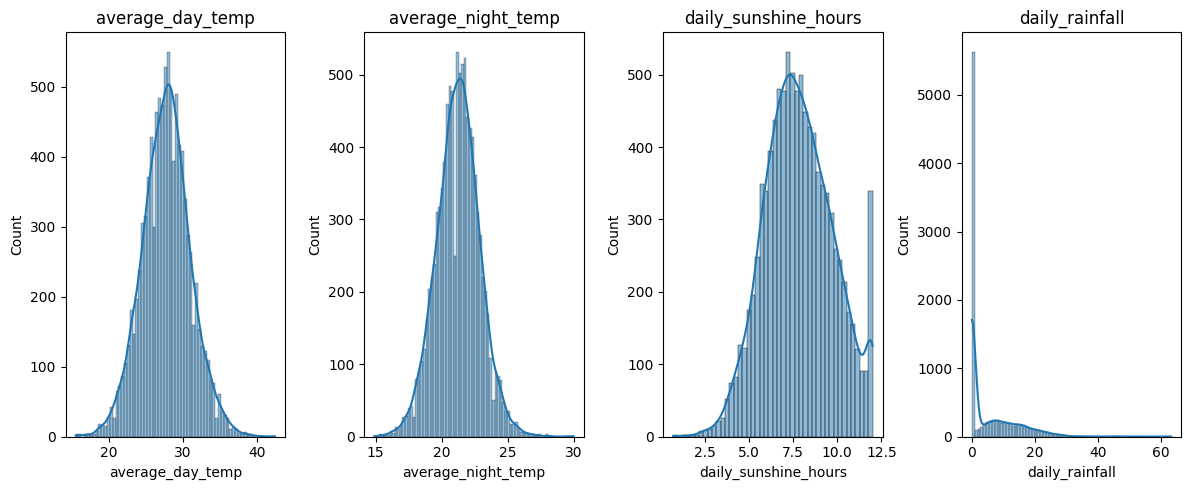

In [6]:
# Observe the data distribution
def plot_histogram(df):
    numerical_columns = df.select_dtypes(include='number').columns
    fig, axes = plt.subplots(int(np.ceil(len(numerical_columns) / 5)), 5, figsize=(15, 5))
    axes = axes.flatten()
    for i, column in enumerate(numerical_columns):
        sns.histplot(df[column], ax=axes[i], kde=True)
        axes[i].set_title(column)
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_histogram(df)

- **Categorical Features:** Count plots for categorical variables.

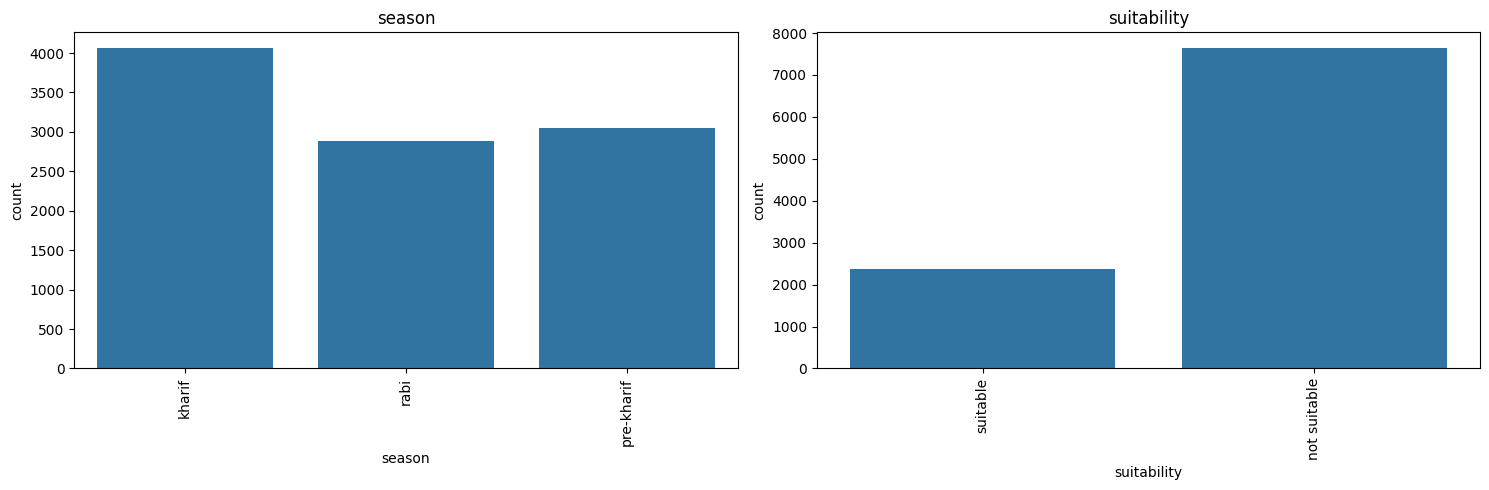

In [7]:
def plot_countplot(df):
    categorical_columns = df.select_dtypes(include='object').columns
    fig, axes = plt.subplots(int(np.ceil(len(categorical_columns) / 2)), 2, figsize=(15, 5))
    axes = axes.flatten()
    for i, column in enumerate(categorical_columns):
        sns.countplot(x=df[column], ax=axes[i])
        axes[i].set_title(column)
        axes[i].tick_params(axis='x', rotation=90)
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_countplot(df)

## **3. Data Cleaning**

### **3.1 Missing Values**

Check for missing values in the dataset.

In [8]:

# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print("Missing values found in the following columns:")
    print(missing_values)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


### **3.2 Duplicates**

Identify and report duplicate rows.

In [9]:
# Check for duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Duplicate rows found: {duplicates}")
else:
    print("No duplicate rows found in the dataset.")

Duplicate rows found: 1


In [10]:
# Remove duplicates
df.drop_duplicates(inplace=True)

### **3.3 Outliers**

Visualize and remove outliers using the Interquartile Range (IQR) method.

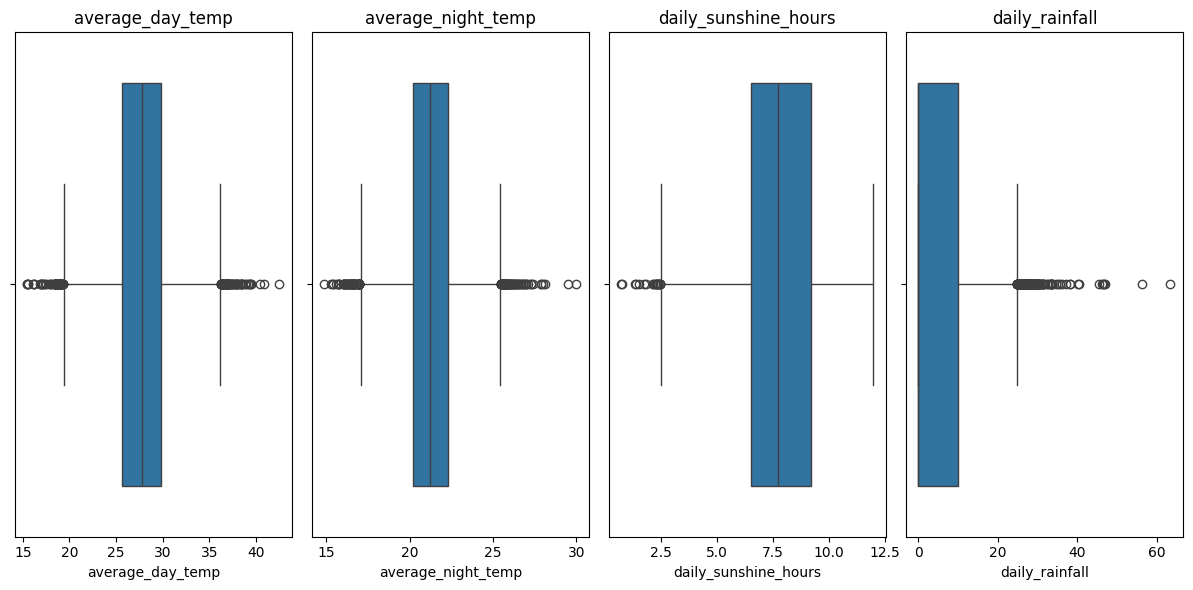

In [11]:
# Check for outliers and visualize them
def plot_boxplot(df):
    numerical_columns = df.select_dtypes(include='number').columns
    fig, axes = plt.subplots(int(np.ceil(len(numerical_columns) / 5)), 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, column in enumerate(numerical_columns):
        sns.boxplot(x=df[column], ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_boxplot(df)

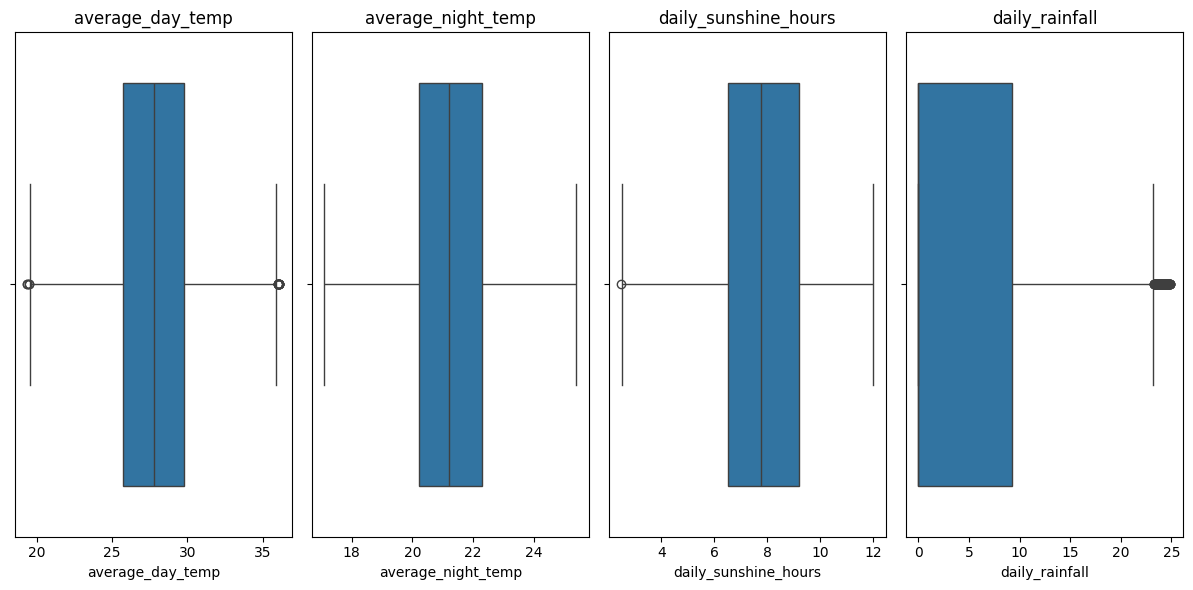

In [12]:
# Remove outliers using IQR method
def remove_outliers_iqr(df):
    numerical_columns = df.select_dtypes(include='number').columns
    # Remove the target variable from the list of numerical columns
    target_variable = 'suitability'  # Replace with your actual target variable name
    if target_variable in numerical_columns:
        numerical_columns = numerical_columns[numerical_columns != target_variable]
    # Calculate IQR and remove outliers
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df_no_outliers = remove_outliers_iqr(df)
plot_boxplot(df_no_outliers)

## **4. Feature Engineering**

### **4.1 Multicollinearity**

Assess correlations between numerical features to identify multicollinearity.

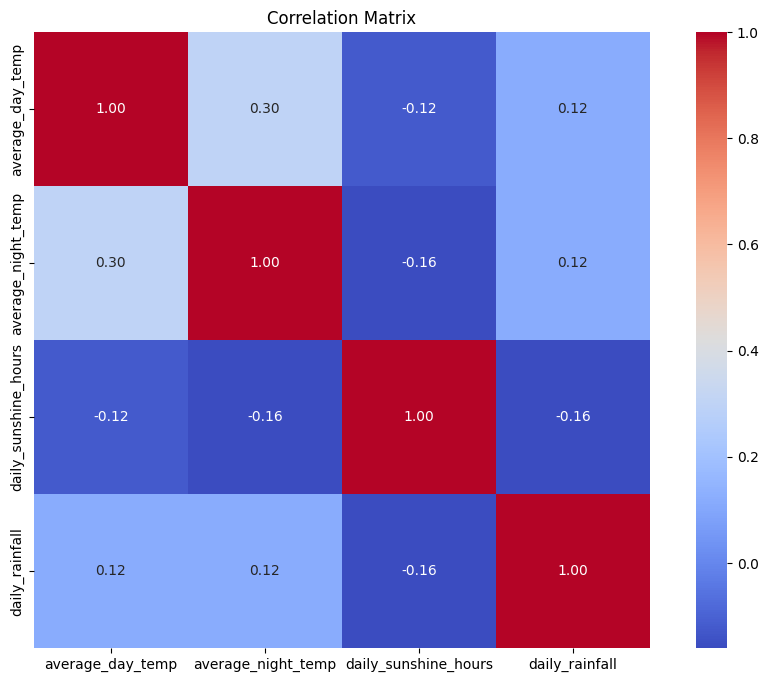

In [13]:
# Check for multicollinearity
def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr(numeric_only=True)
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Matrix')
    plt.show()
plot_correlation_matrix(df_no_outliers)

### **4.2 Class Imbalance**

Check the distribution of the target variable (suitability).

In [14]:
# Check for class imbalance
df_no_outliers['suitability'].value_counts()

suitability
not suitable    7243
suitable        2266
Name: count, dtype: int64

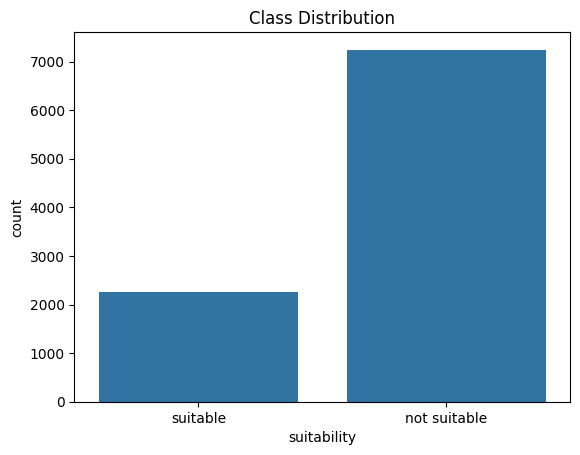

In [15]:
# Plot class distribution
def plot_class_distribution(df):
    target_column = 'suitability'  # Replace with your target column name
    sns.countplot(x=df[target_column])
    plt.title('Class Distribution')
    plt.show()
plot_class_distribution(df_no_outliers)

### **4.3 Encode Categorical Variables**

Convert categorical variables to numerical codes.

In [16]:
numerical_columns = df_no_outliers.select_dtypes(include='number').columns
categorical_columns = df_no_outliers.select_dtypes(include='object').columns
print("Number of numerical columns:", len(numerical_columns))
print("Numerical columns:", numerical_columns)
print("Number of categorical columns:", len(categorical_columns))
print("Categorical columns:", categorical_columns)

Number of numerical columns: 4
Numerical columns: Index(['average_day_temp', 'average_night_temp', 'daily_sunshine_hours',
       'daily_rainfall'],
      dtype='object')
Number of categorical columns: 2
Categorical columns: Index(['season', 'suitability'], dtype='object')


In [17]:
# Encode categorical variables using LabelEncoder
def encode_categorical_variables(df):
    categorical_columns = df.select_dtypes(include='object').columns
    for column in categorical_columns:
        df[column] = df[column].astype('category').cat.codes
    print("Categorical variables encoded successfully.")
    return df
df_encoded = encode_categorical_variables(df_no_outliers)

Categorical variables encoded successfully.


In [18]:
df_encoded

,season,average_day_temp,average_night_temp,daily_sunshine_hours,daily_rainfall,suitability
0,0,28.6,21.3,7.572613,13.114609,1
1,2,25.9,21.5,5.692076,0.000000,0
2,2,26.0,19.9,11.612907,0.000000,0
3,0,27.1,20.2,8.504957,22.802553,1
4,1,25.7,22.5,7.830067,5.836964,1
...,...,...,...,...,...,...
9995,2,27.2,21.0,8.047391,4.746659,1
9996,2,24.2,19.6,10.716155,0.000000,0
9997,2,26.6,19.2,10.895600,0.000000,0
9998,0,29.9,20.0,7.960959,0.000000,0


## **5. Data Preprocessing**

### **5.1 Separate Features and Target**

Split the dataset into features (X) and target (y).

In [19]:
# Separate features and target
X = df_encoded.drop('suitability', axis=1)
y = df_encoded['suitability']

print("Shape of Features:", X.shape)
print("Shape of Target:", y.shape)

Shape of Features: (9509, 5)
Shape of Target: (9509,)


### **5.2 Handle Class Imbalance**

Use SMOTE to oversample the minority class.

In [20]:
# Upsample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

Class distribution after SMOTE:
suitability
1    7243
0    7243
Name: count, dtype: int64


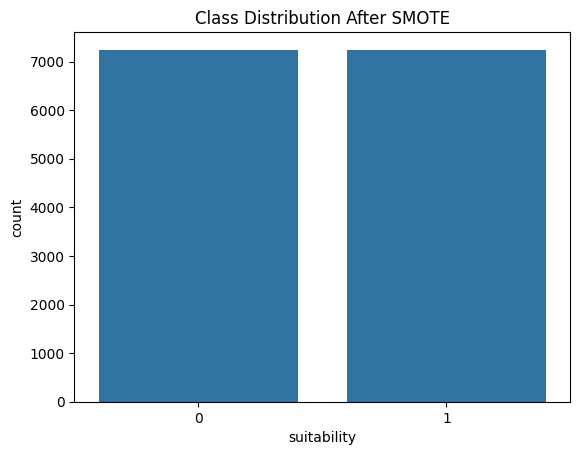

In [21]:
# Visualize the class distribution after SMOTE
def plot_class_distribution_after_smote(y_resampled):
    sns.countplot(x=y_resampled)
    plt.title('Class Distribution After SMOTE')
    plt.show()
plot_class_distribution_after_smote(y_resampled)

### **5.3 Scale Features**

Standardize features to ensure consistent scales.

In [22]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)
print("Shape of Training Data:", X_train.shape)
print("Shape of Testing Data:", X_test.shape)

Shape of Training Data: (11588, 5)
Shape of Testing Data: (2898, 5)


## **6. Model Training and Evaluation**

### **6.1 Train Multiple Models**

Evaluate a range of classifiers: Logistic Regression, SVM, KNN, Random Forest, Gradient Boosting, XGBoost, and LightGBM.

In [23]:
# Define a dictionary of models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(verbose=-1)
}

results = []  # List to store performance metrics for each model

# Train each model and evaluate its performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Use predict_proba to calculate ROC AUC if available
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    # Print performance metrics
    print(f"Model: {name}")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    if not np.isnan(roc_auc):
        print(f"  ROC AUC  : {roc_auc:.4f}")
    else:
        print("  ROC AUC  : Not available")
    print("-" * 40)

    # Append results to list
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

# Store the results in a dataframe and print
results_df = pd.DataFrame(results)
print("Summary of model performance:")
print(results_df)

# Save the model results
results_df.to_csv('base_model_performance.csv', index=False)

Model: Logistic Regression
  Accuracy : 0.8471
  Precision: 0.8572
  Recall   : 0.8279
  F1 Score : 0.8423
  ROC AUC  : 0.9112
----------------------------------------
Model: SVM
  Accuracy : 0.9800
  Precision: 0.9744
  Recall   : 0.9853
  F1 Score : 0.9798
  ROC AUC  : 0.9988
----------------------------------------
Model: KNN
  Accuracy : 0.9758
  Precision: 0.9594
  Recall   : 0.9930
  F1 Score : 0.9759
  ROC AUC  : 0.9930
----------------------------------------
Model: Random Forest
  Accuracy : 0.9997
  Precision: 1.0000
  Recall   : 0.9993
  F1 Score : 0.9996
  ROC AUC  : 1.0000
----------------------------------------
Model: XGBoost
  Accuracy : 0.9997
  Precision: 1.0000
  Recall   : 0.9993
  F1 Score : 0.9996
  ROC AUC  : 0.9996
----------------------------------------
Model: LightGBM
  Accuracy : 0.9997
  Precision: 0.9993
  Recall   : 1.0000
  F1 Score : 0.9997
  ROC AUC  : 1.0000
----------------------------------------
Summary of model performance:
                 Model 

### **6.2 Visualize Model Performance**

Compare model performance across metrics.

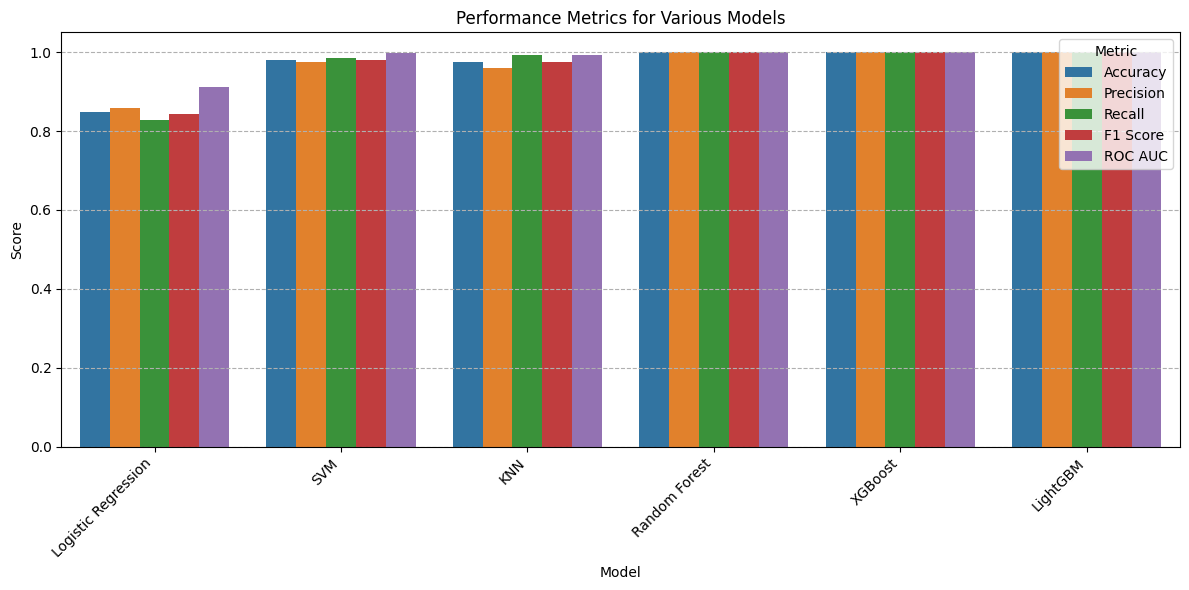

In [24]:
# Plot the performance metrics
# Melt the results_df so that each row represents a metric score for a given model
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title("Performance Metrics for Various Models")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--')
plt.tight_layout()

# Save the figure
plt.savefig('figures/base_model_performance.png')
# Show the plot
plt.show()

## **7. Stacking Classifier**

Combine top-performing models using a stacking classifier with Logistic Regression as the final estimator.

In [25]:
# Create a Stacking Classifier with the 5 best models
base_models = [
    ('SVM', SVC(probability=True)),
    ('KNN', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier(verbose=-1))
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)
# Train the stacking model
stacking_model.fit(X_train, y_train)
# Evaluate the stacking model on the test set
y_pred_stacking = stacking_model.predict(X_test)
y_proba_stacking = stacking_model.predict_proba(X_test)[:, 1] if hasattr(stacking_model, "predict_proba") else None
# Calculate performance metrics for the stacking model
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking, zero_division=0)
recall_stacking = recall_score(y_test, y_pred_stacking, zero_division=0)
f1_stacking = f1_score(y_test, y_pred_stacking, zero_division=0)
roc_auc_stacking = roc_auc_score(y_test, y_proba_stacking) if y_proba_stacking is not None else np.nan
# Print performance metrics for the stacking model
print(f"Stacking Model:")
print(f"  Accuracy : {accuracy_stacking:.4f}")
print(f"  Precision: {precision_stacking:.4f}")
print(f"  Recall   : {recall_stacking:.4f}")
print(f"  F1 Score : {f1_stacking:.4f}")
if not np.isnan(roc_auc_stacking):
    print(f"  ROC AUC  : {roc_auc_stacking:.4f}")
else:
    print("  ROC AUC  : Not available")
print("-" * 40)

Stacking Model:
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1 Score : 1.0000
  ROC AUC  : 1.0000
----------------------------------------


In [26]:
# Save the final model
joblib.dump(stacking_model, 'stacking_model.pkl')

['stacking_model.pkl']

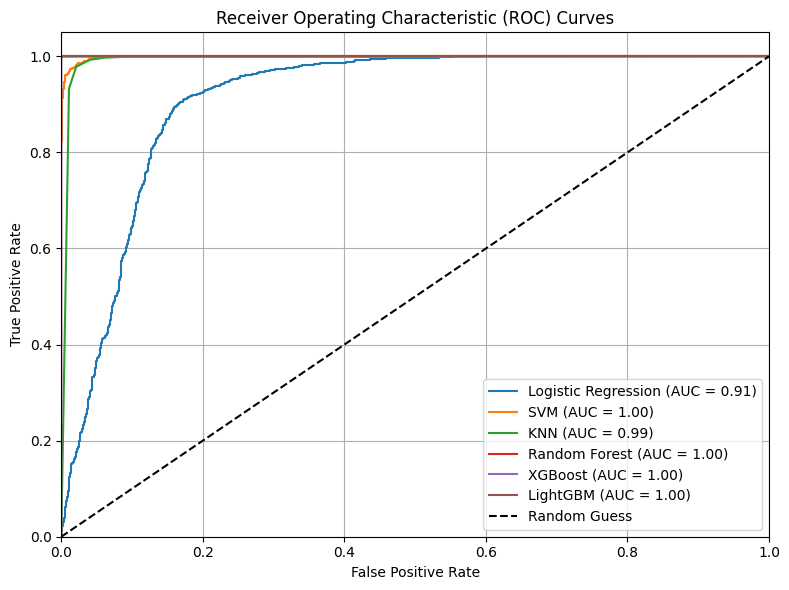

In [30]:
# Plot ROC curve for all models in one figure
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_test, models, X_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('figures/roc_curves.png')
    plt.show()

# Call the function to plot ROC curves
plot_roc_curves(y_test, models, X_test)

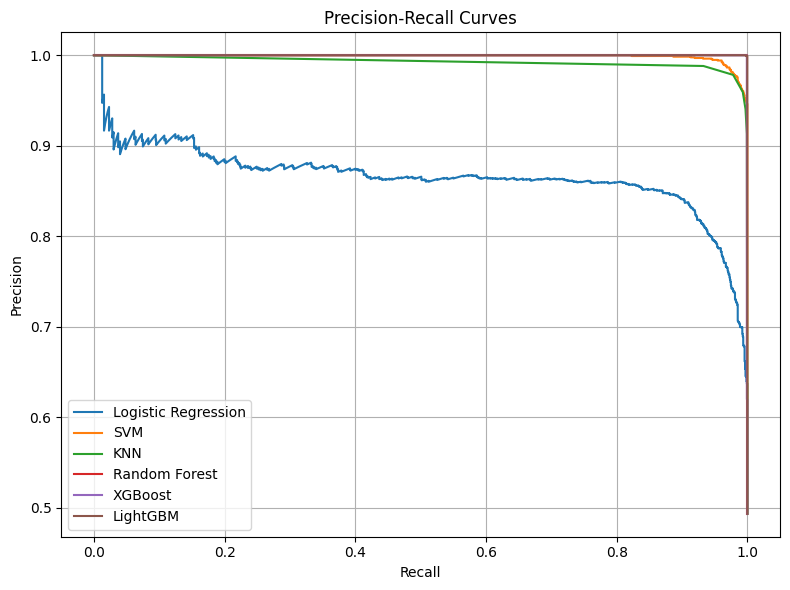

In [31]:
# Plot Precision-Recall curve for all models in one figure
from sklearn.metrics import precision_recall_curve
def plot_precision_recall_curves(y_test, models, X_test):
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            plt.plot(recall, precision, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('figures/precision_recall_curves.png')
    plt.show()
# Call the function to plot Precision-Recall curves
plot_precision_recall_curves(y_test, models, X_test)

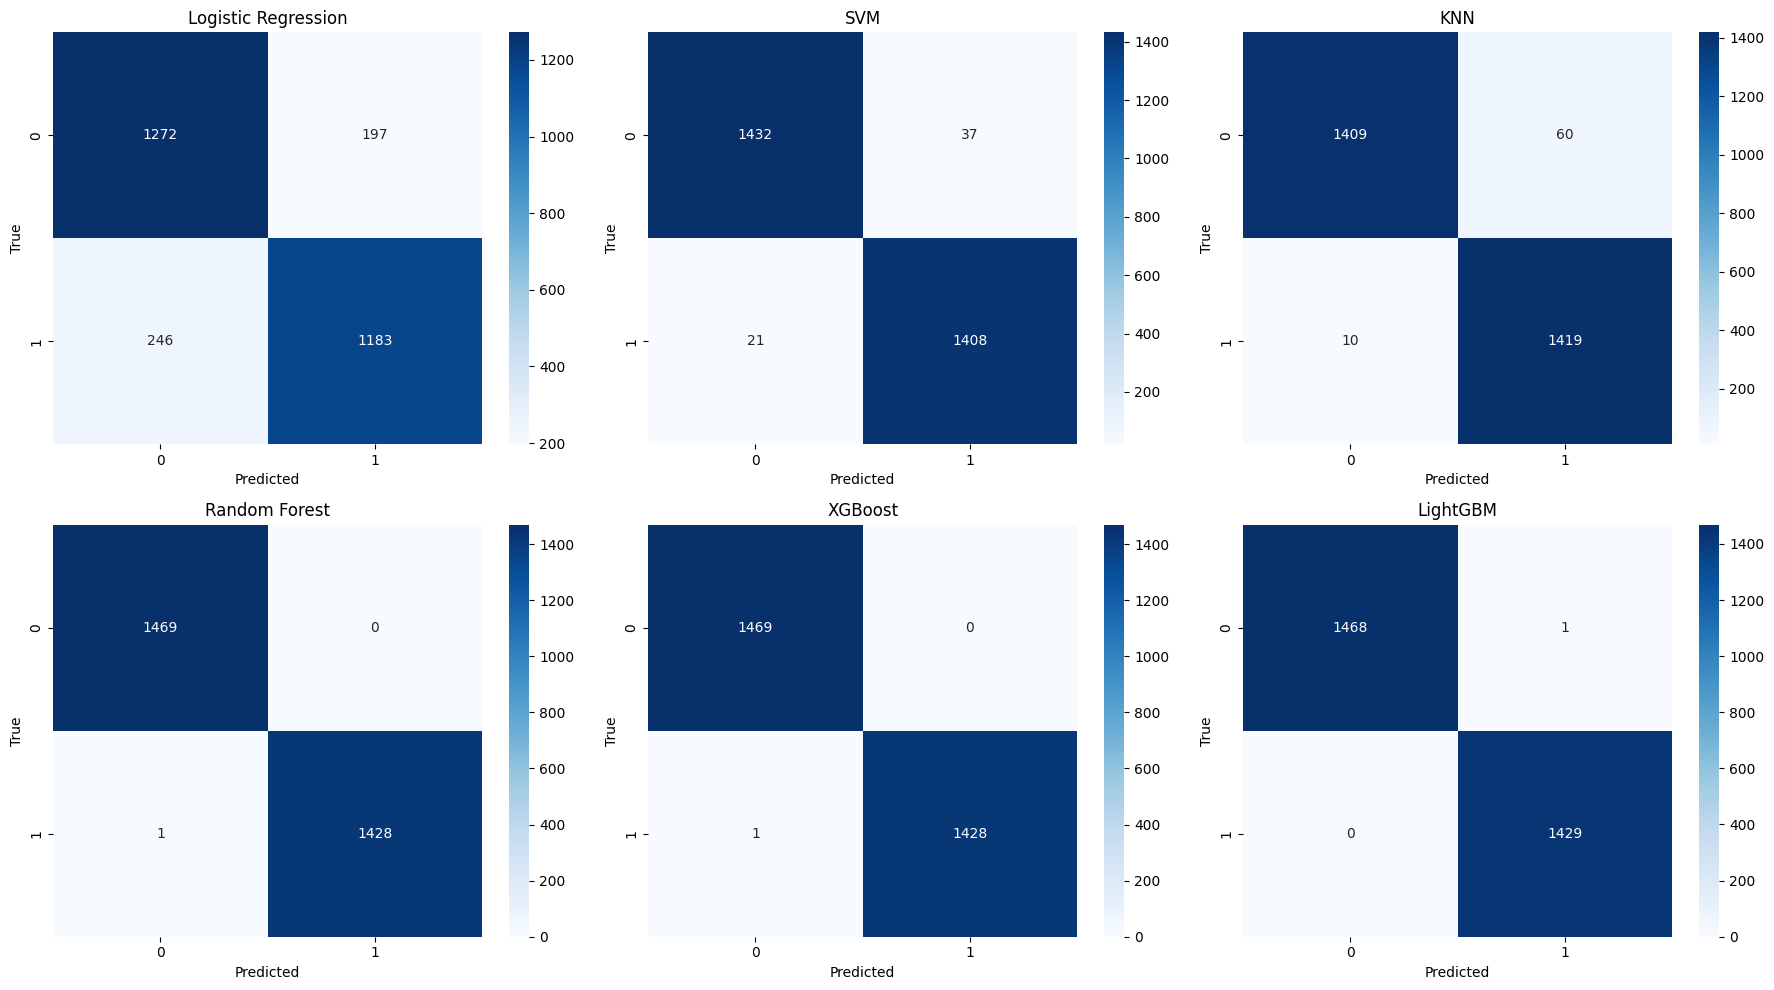

In [32]:
# plot confusion matrix of all models in one figure
def plot_confusion_matrices(y_test, models, X_test):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    for i, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(name)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    plt.tight_layout()
    plt.savefig('figures/confusion_matrices.png')
    plt.show()
# Call the function to plot confusion matrices
plot_confusion_matrices(y_test, models, X_test)